In [1]:
%matplotlib inline
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import scipy
from scipy.optimize import curve_fit
from scipy import stats
import h5py

#this sets the size of the plot to something useful
plt.rcParams["figure.figsize"] = (15,10)
plt.style.use('seaborn')

In [2]:
hf = h5py.File('gammaray_lab4.h5', 'r')
data = np.array(hf.get('data'))
hf.close()

In [3]:
time = data[0,:]
solar_phase = data[1,:]
earth_long = data[2,:]
part_count = data[3,:]

### Problem 1

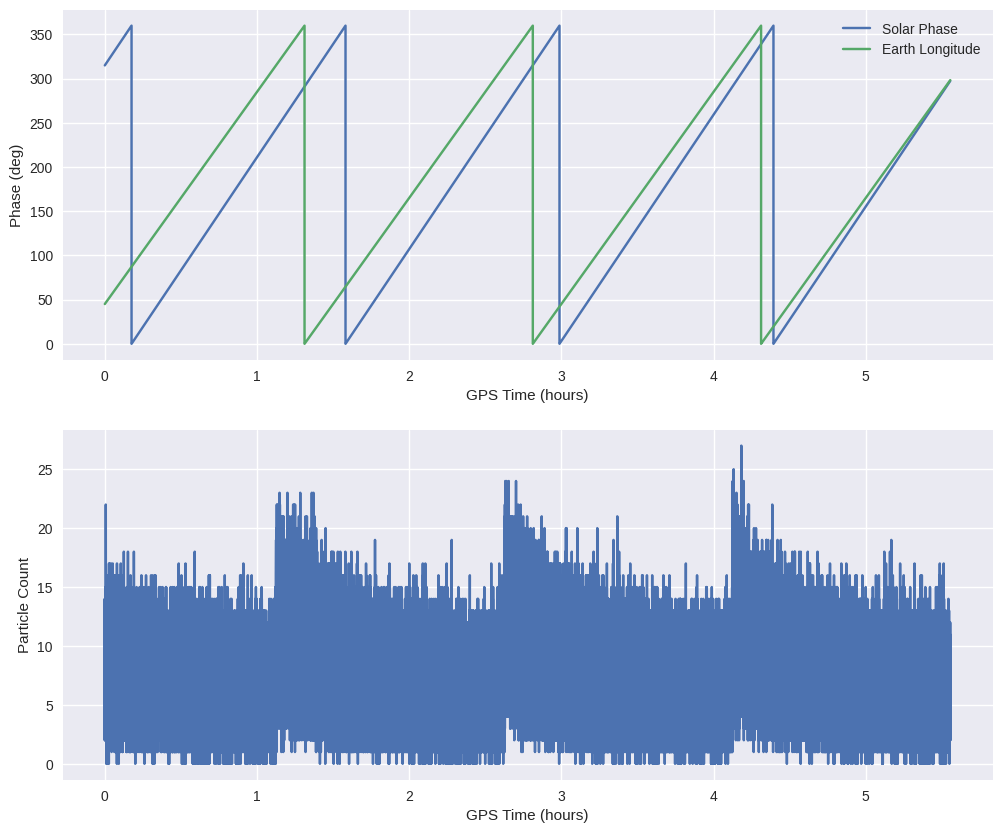

In [4]:
fig, ax = plt.subplots(2, 1, figsize=(12, 10))

time_fix = time - data[0,0]
time_hours = time_fix / 60 / 60
time_mins = time_fix / 60

ax[0].plot(time_hours[0:200000], solar_phase[0:200000], label="Solar Phase")
ax[0].plot(time_hours[0:200000], earth_long[0:200000], label="Earth Longitude")
ax[0].set_xlabel("GPS Time (hours)")
ax[0].set_ylabel("Phase (deg)")
ax[0].legend(loc=0)

ax[1].plot(time_hours[0:200000], part_count[0:200000])
ax[1].set_xlabel("GPS Time (hours)")
ax[1].set_ylabel("Particle Count")

plt.show()

Data features:
- Earth longitude has a slightly longer period than solar phase (earth spins and the satellite rotates)

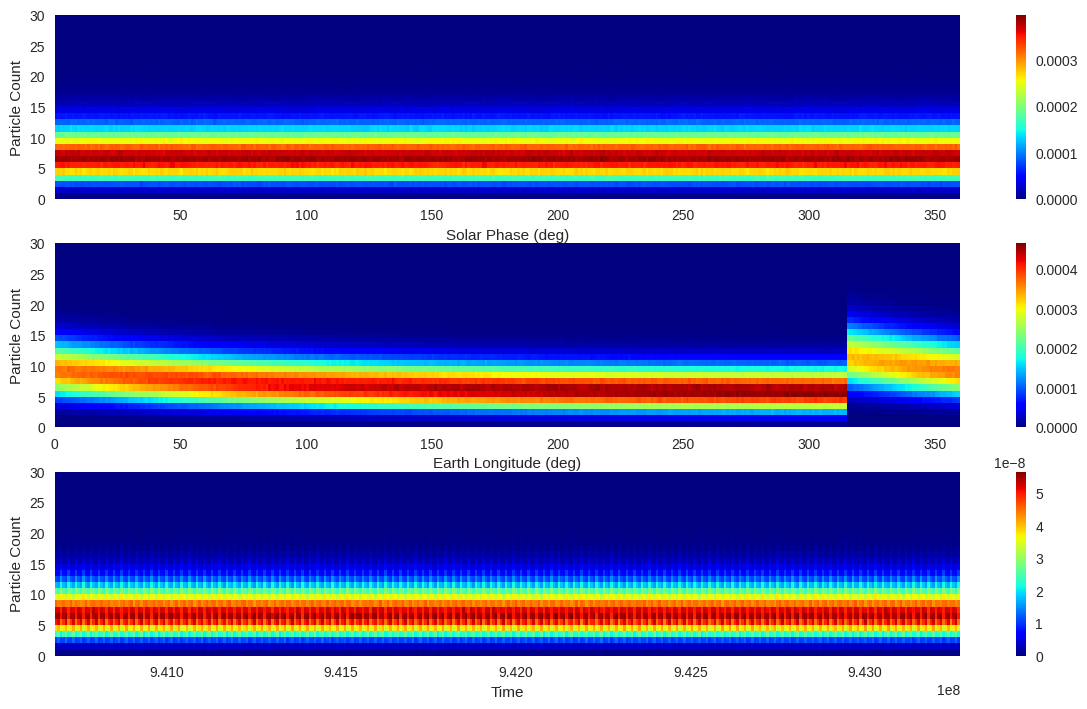

In [7]:
fig, ax = plt.subplots(3,1, figsize=(12,7))
fig.tight_layout()

g = ax[0].hist2d(solar_phase, part_count, bins=(360, 30), cmap=plt.cm.jet, density=True)
ax[0].set_xlabel("Solar Phase (deg)")
ax[0].set_ylabel("Particle Count")
plt.colorbar(g[3], ax=ax[0])

h = ax[1].hist2d(earth_long, part_count, bins=(360, 30), cmap=plt.cm.jet, density=True)
ax[1].set_xlabel("Earth Longitude (deg)")
ax[1].set_ylabel("Particle Count")
plt.colorbar(h[3], ax=ax[1])

i = ax[2].hist2d(time, part_count, bins=(360, 30), cmap=plt.cm.jet, density=True)
ax[2].set_xlabel("Time")
ax[2].set_ylabel("Particle Count")
plt.colorbar(i[3], ax=ax[2])

plt.show()

Data features:
- Particle count (background) does not depend on solar phase or time, but it does depend on earth longitude

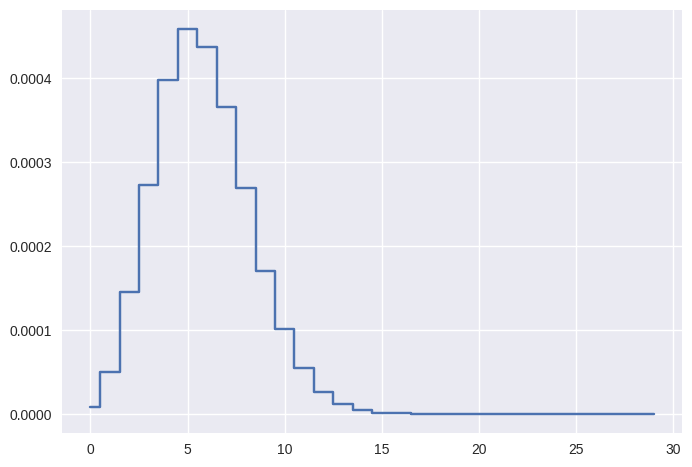

In [8]:
fig, ax = plt.subplots(1,1)

x = np.arange(0, part_count.max(), 1)
ax.step(x, h[0][310], where='mid')
plt.show()

The probability distribution of the particles at the nth degree

In [9]:
g = h

means = []
for i in range(len(g[1])-1):
    g[0][i] = g[0][i] / np.sum(g[0][i])
    av = 0
    for n in range(len(g[0][i])-1):
        av = av + (g[0][i][n] * n)
    means.append(av)
    
index = 0
for i in range(len(means) - 1):
    if(means[i] >= max(means)):
        index = i
        break
        
shifted_means = means[0:index]
for i in range(len(h[1]) - index):
    shifted_means = np.insert(shifted_means, 0, means[-i])

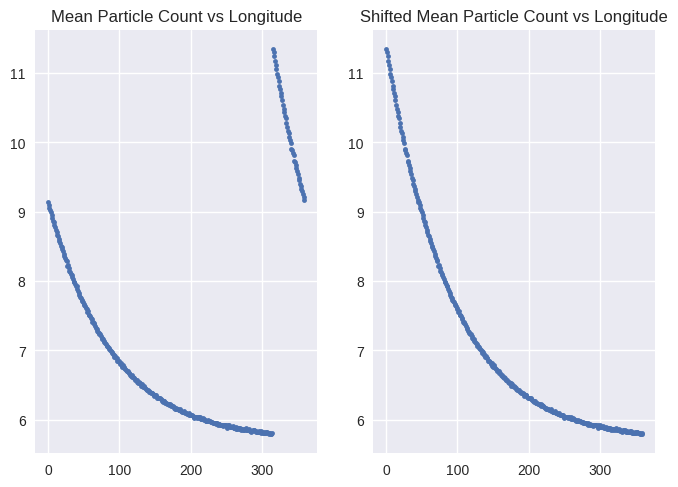

In [10]:
fig, ax = plt.subplots(1,2)

deg = np.arange(0, 361, 1)

ax[1].plot(deg, shifted_means, '.')
ax[1].set_title("Shifted Mean Particle Count vs Longitude")

ax[0].plot(deg[0:360], means, '.')
ax[0].set_title("Mean Particle Count vs Longitude")

plt.show()

In [11]:
def fit(x, a, b, c, d):
    return a*np.exp(b*(x+c)) + d

guess_a = 11
guess_b = -0.01
guess_c = -10              
guess_d = 10

init_guesses = [guess_a, guess_b, guess_c, guess_d]

In [12]:
fitpars, error = curve_fit(fit,
                          deg, shifted_means,
                          init_guesses)

print(fitpars)

[ 1.74826549e+01 -1.09500085e-02  1.02914574e+02  5.68967182e+00]


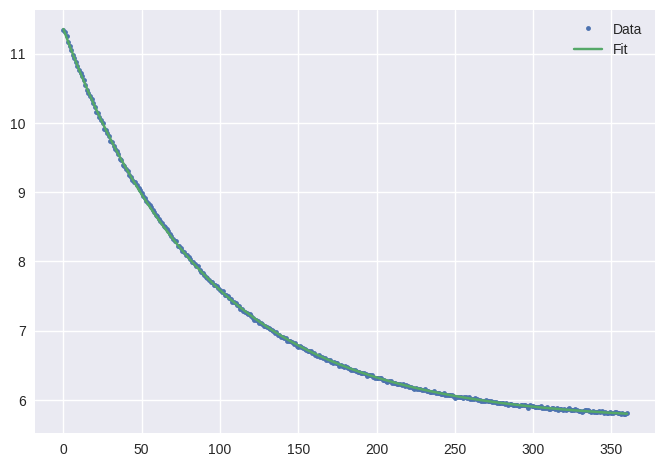

In [15]:
fig, ax = plt.subplots(1,1)

x = deg
y = shifted_means

ax.plot(x, y, '.', label='Data')

ax.plot(x, fit(x, *fitpars), label='Fit')

plt.legend(loc=0)
plt.show()

#### Model: 

$
\large
\lambda = 6.74e^{-0.011(x+15.8))} + 5.69
$
, where $x$ is the longitudinal degree.

Find $\lambda$ at a given time

In [16]:
# time in minutes

def find_lambda(t_min):
    time_index = np.where(time_mins == t_min)
    degree = earth_long[time_index][0]
    lambda_value = fitpars[0]*np.exp(fitpars[1]*(degree+fitpars[2])) + fitpars[3]
    return degree, lambda_value

In [17]:
t = 30
degree_1 = find_lambda(t)[0]
lambda_value_1 = find_lambda(t)[1]

print("At "+str(t)+" minutes, the satellite is at "+str(degree_1)+" degrees of longitude.")
print("This corresponds to a background Poisson with a mean of "+str(lambda_value_1))

At 30 minutes, the satellite is at 165.0 degrees of longitude.
This corresponds to a background Poisson with a mean of 6.619776984749255


In [18]:
t = 45
degree_2 = find_lambda(t)[0]
lambda_value_2 = find_lambda(t)[1]

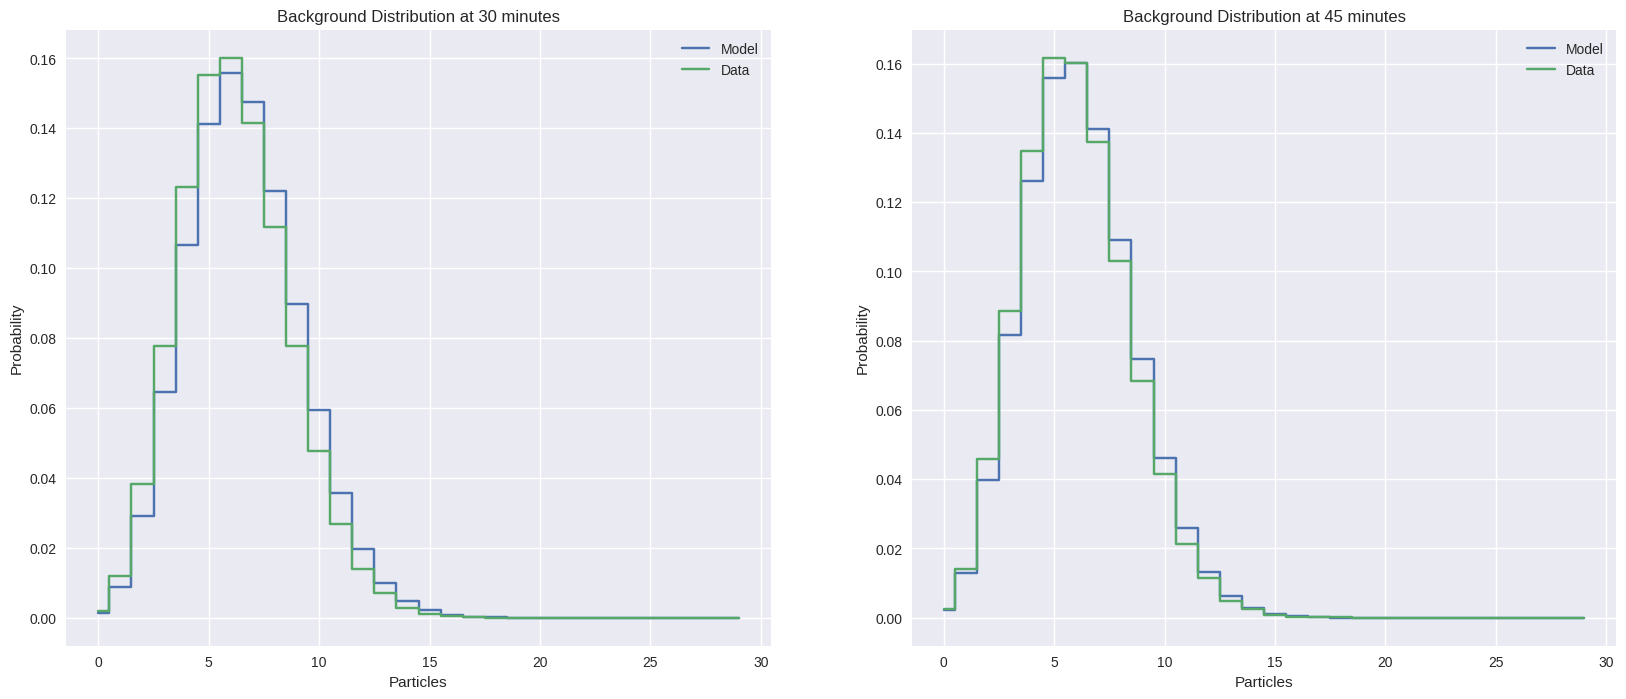

In [19]:
fig, ax = plt.subplots(1, 2, figsize=(20, 8))

x = np.arange(0, 30, 1)

y_1 = stats.poisson.pmf(x, lambda_value_1)
ax[0].step(x, y_1, where='mid', label='Model')
ax[0].step(x, h[0][int(degree_1)], where='mid', label='Data')
ax[0].set_xlabel("Particles")
ax[0].set_ylabel("Probability")
ax[0].set_title("Background Distribution at 30 minutes")

y_2 = stats.poisson.pmf(x, lambda_value_2)
ax[1].step(x, y_2, where='mid', label='Model')
ax[1].step(x, h[0][int(degree_2)], where='mid', label='Data')
ax[1].set_xlabel("Particles")
ax[1].set_ylabel("Probability")
ax[1].set_title("Background Distribution at 45 minutes")

ax[0].legend(loc=0)
ax[1].legend(loc=0)

plt.show()

In [20]:
prob5sigma = stats.norm.cdf(5, loc=0, scale=1)

measurement_val_1 = stats.poisson.ppf(prob5sigma, lambda_value_1, loc=0)
measurement_val_2 = stats.poisson.ppf(prob5sigma, lambda_value_2, loc=0)

print(measurement_val_1, measurement_val_2)

23.0 22.0


### Problem 2

In [110]:
import h5py
import numpy as np
import io
from PIL import Image

hf = h5py.File('images.h5', 'r')
print(hf.keys())

image1 = hf['image1']
imagestack = hf['imagestack']
print(imagestack.shape)

<KeysViewHDF5 ['image1', 'imagestack']>
(200, 200)


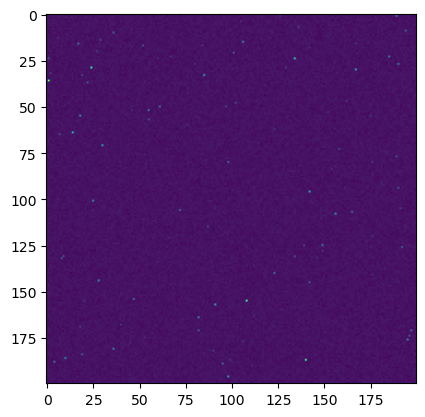

In [218]:
plt.style.use('default')
plt.subplots(1,1)
plt.imshow(image1)
plt.show()

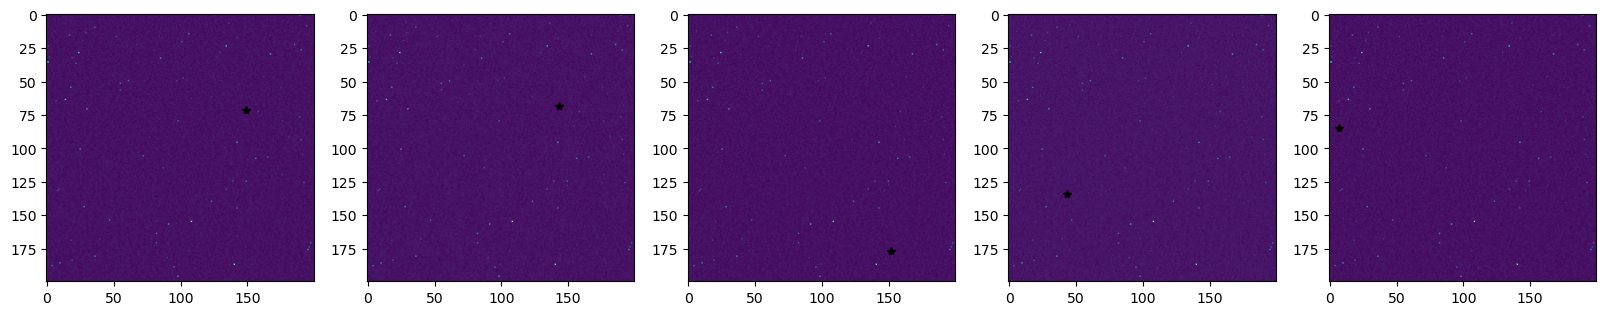

In [221]:
fig, ax = plt.subplots(1, 5, figsize=(20,20))

for i in range(5):
    h = imagestack[:,:,i]
    h_min = abs(h).min()
    index = np.where(abs(h)==h_min)
    
    ax[i].imshow(h)
    ax[i].plot(index[0][0], index[1][0], 'k*')
    
plt.show()

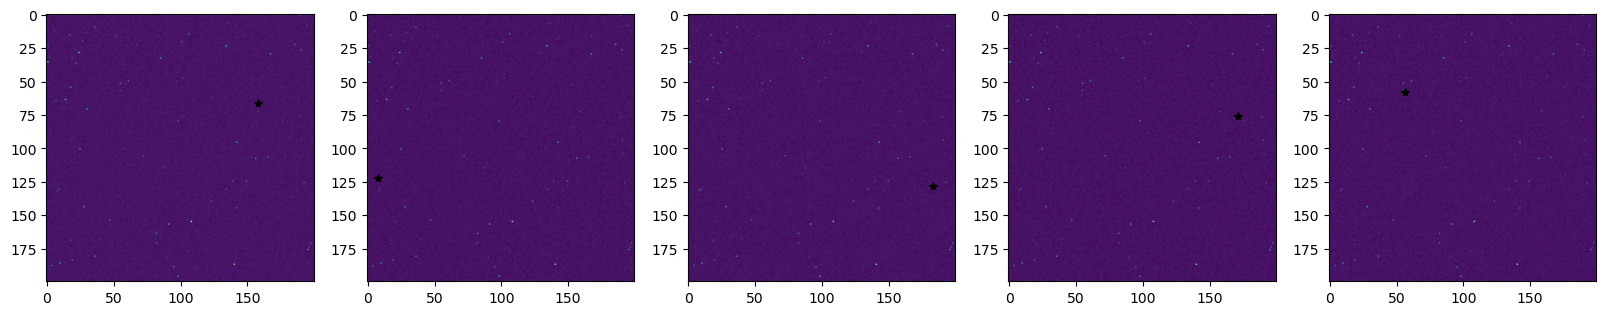

In [231]:
fig, ax = plt.subplots(1, 5, figsize=(20,20))

for i in range(5):
    h = imagestack[:,:,i+5]
    h_min = abs(h).min()
    index = np.where(abs(h)==h_min)
    
    ax[i].imshow(h)
    ax[i].plot(index[0][0], index[1][0], 'k*')
    
plt.show()

In [235]:
h_min_array = []
for i in range(10):
    h = imagestack[:,:,i]
    h_min = abs(h).min()
    h_min_array = np.append(h_min_array, h_min)
    index = np.where(abs(h)==h_min)
    
h_min_array

array([3.39444702e-05, 5.54065895e-05, 1.05700071e-06, 2.20005826e-05,
       2.20442926e-05, 8.45215592e-06, 1.25861925e-06, 1.68084804e-05,
       7.50264776e-06, 3.34369612e-06])